In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
from tqdm.notebook import tqdm 
import h5py
#%matplotlib widget

In [2]:
datapath ="./dane vibstand/"
filelist = os.listdir(datapath)
print(sorted(filelist))
filenames  =sorted(filelist)
df_list = []
for filename in sorted(filelist):
    f = h5py.File(datapath +filename,'r')
    data_names = np.array(f.get('/'))
    dictionary = {}
    for i in range(0,len(data_names)-1):
        name = data_names[i]
        dictionary.update({name : np.array(f.get('/'+name)).T[0]})
    df = pd.DataFrame.from_dict(dictionary)
    df_list.append(df)

['speed_10.mat', 'speed_15.mat', 'speed_20.mat', 'speed_25_5.mat']


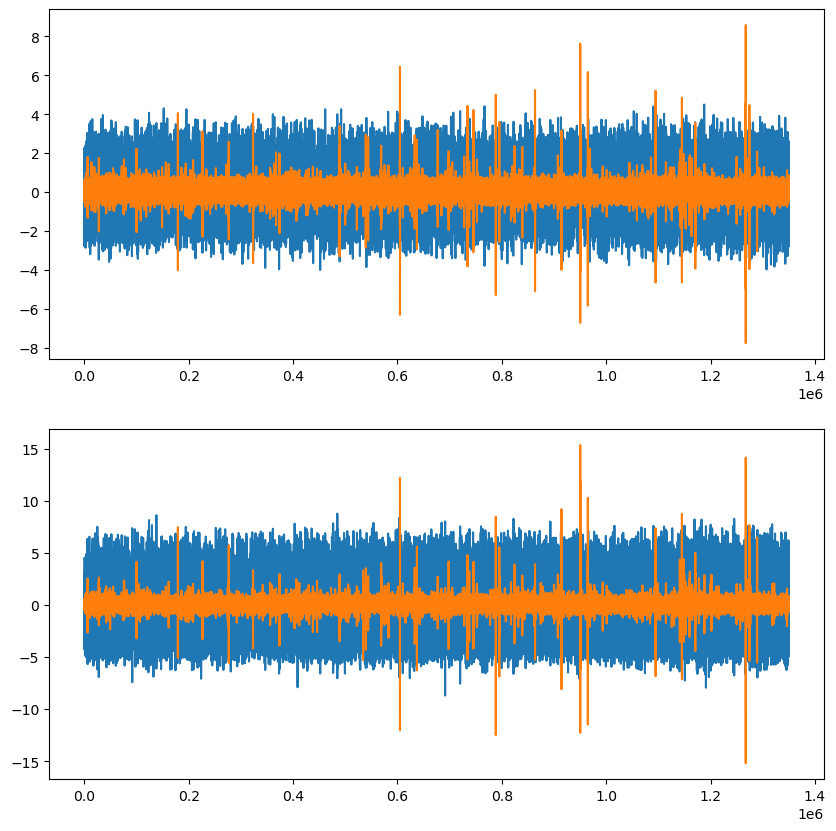

In [3]:
df = df_list[3]
f,ax = plt.subplots(2,1, figsize =(10,10))
ax[0].plot(df["Vib1"])
ax[0].plot(df["Vib3"])
ax[1].plot(df["Vib2"])
ax[1].plot(df["Vib4"])
plt.show()

In [4]:
def compute_diagram(data, dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 100):
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    if len(point_clouds>250):
        skip = max(len(point_clouds)//250,1)
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data])[0] 
    #point_clouds = levy_stable.rvs(alpha,0,0, size=(100,2))

    if (normalize):
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]

    pc = point_clouds
    #print(len(pc))

    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)
    
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    return pd

In [97]:
n_samples = 10
norms = np.zeros((4,4,n_samples))
start = 0#2.98
end = 7#3.7
grid = np.linspace(start,end,10000)
bc = BettiCurve(predefined_grid=grid)
betti_curves = np.zeros((4,4,n_samples,10000))

speeds = [10,15,20,25]


for j in tqdm(range(0,len(df_list))):
    scaling_factor =(j+2)*0.5    
    dim = int(30*(1/(scaling_factor)))
    delay = 1#120#int(60*(1/(scaling_factor)**2))#int(90*scaling_factor)
    
    print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))
    
    skip =1
    for i in range(0,4):
        samples = np.array_split(df_list[j].iloc[:,i].values,n_samples)
        
        for k in range(0,len(samples)):
            pd = compute_diagram(samples[k], dim, delay, skip, normalize = True, weighted = False, point_cloud_size = 250)
            #bc = np.array(compute_bc_from_ts(samples[k], dim, delay, skip))
            curve = np.array(bc.fit_transform([pd])[0])
            betti_curves[j,i,k] = curve
            #norm = compute_norms_from_ts(samples[k], dim, delay, skip)
            norm = wasserstein_distance(pd,[], order=1, internal_p = 1)
            
            norms[j,i,k] = norm

  0%|          | 0/4 [00:00<?, ?it/s]

Speed 10, dim = 30, delay = 1
Speed 15, dim = 20, delay = 1
Speed 20, dim = 15, delay = 1
Speed 25, dim = 12, delay = 1


  0%|          | 0/4 [00:00<?, ?it/s]

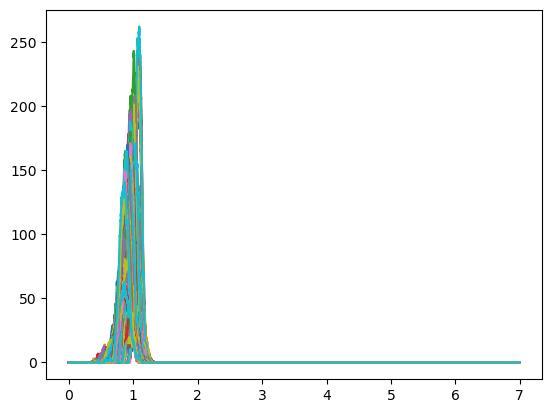

In [98]:
f,ax = plt.subplots()
for j in tqdm(range(0,len(df_list))):
    for i in range(0,4):
        for k in range(0,len(samples)):
            ax.plot(grid, betti_curves[j,i,k])
plt.show()

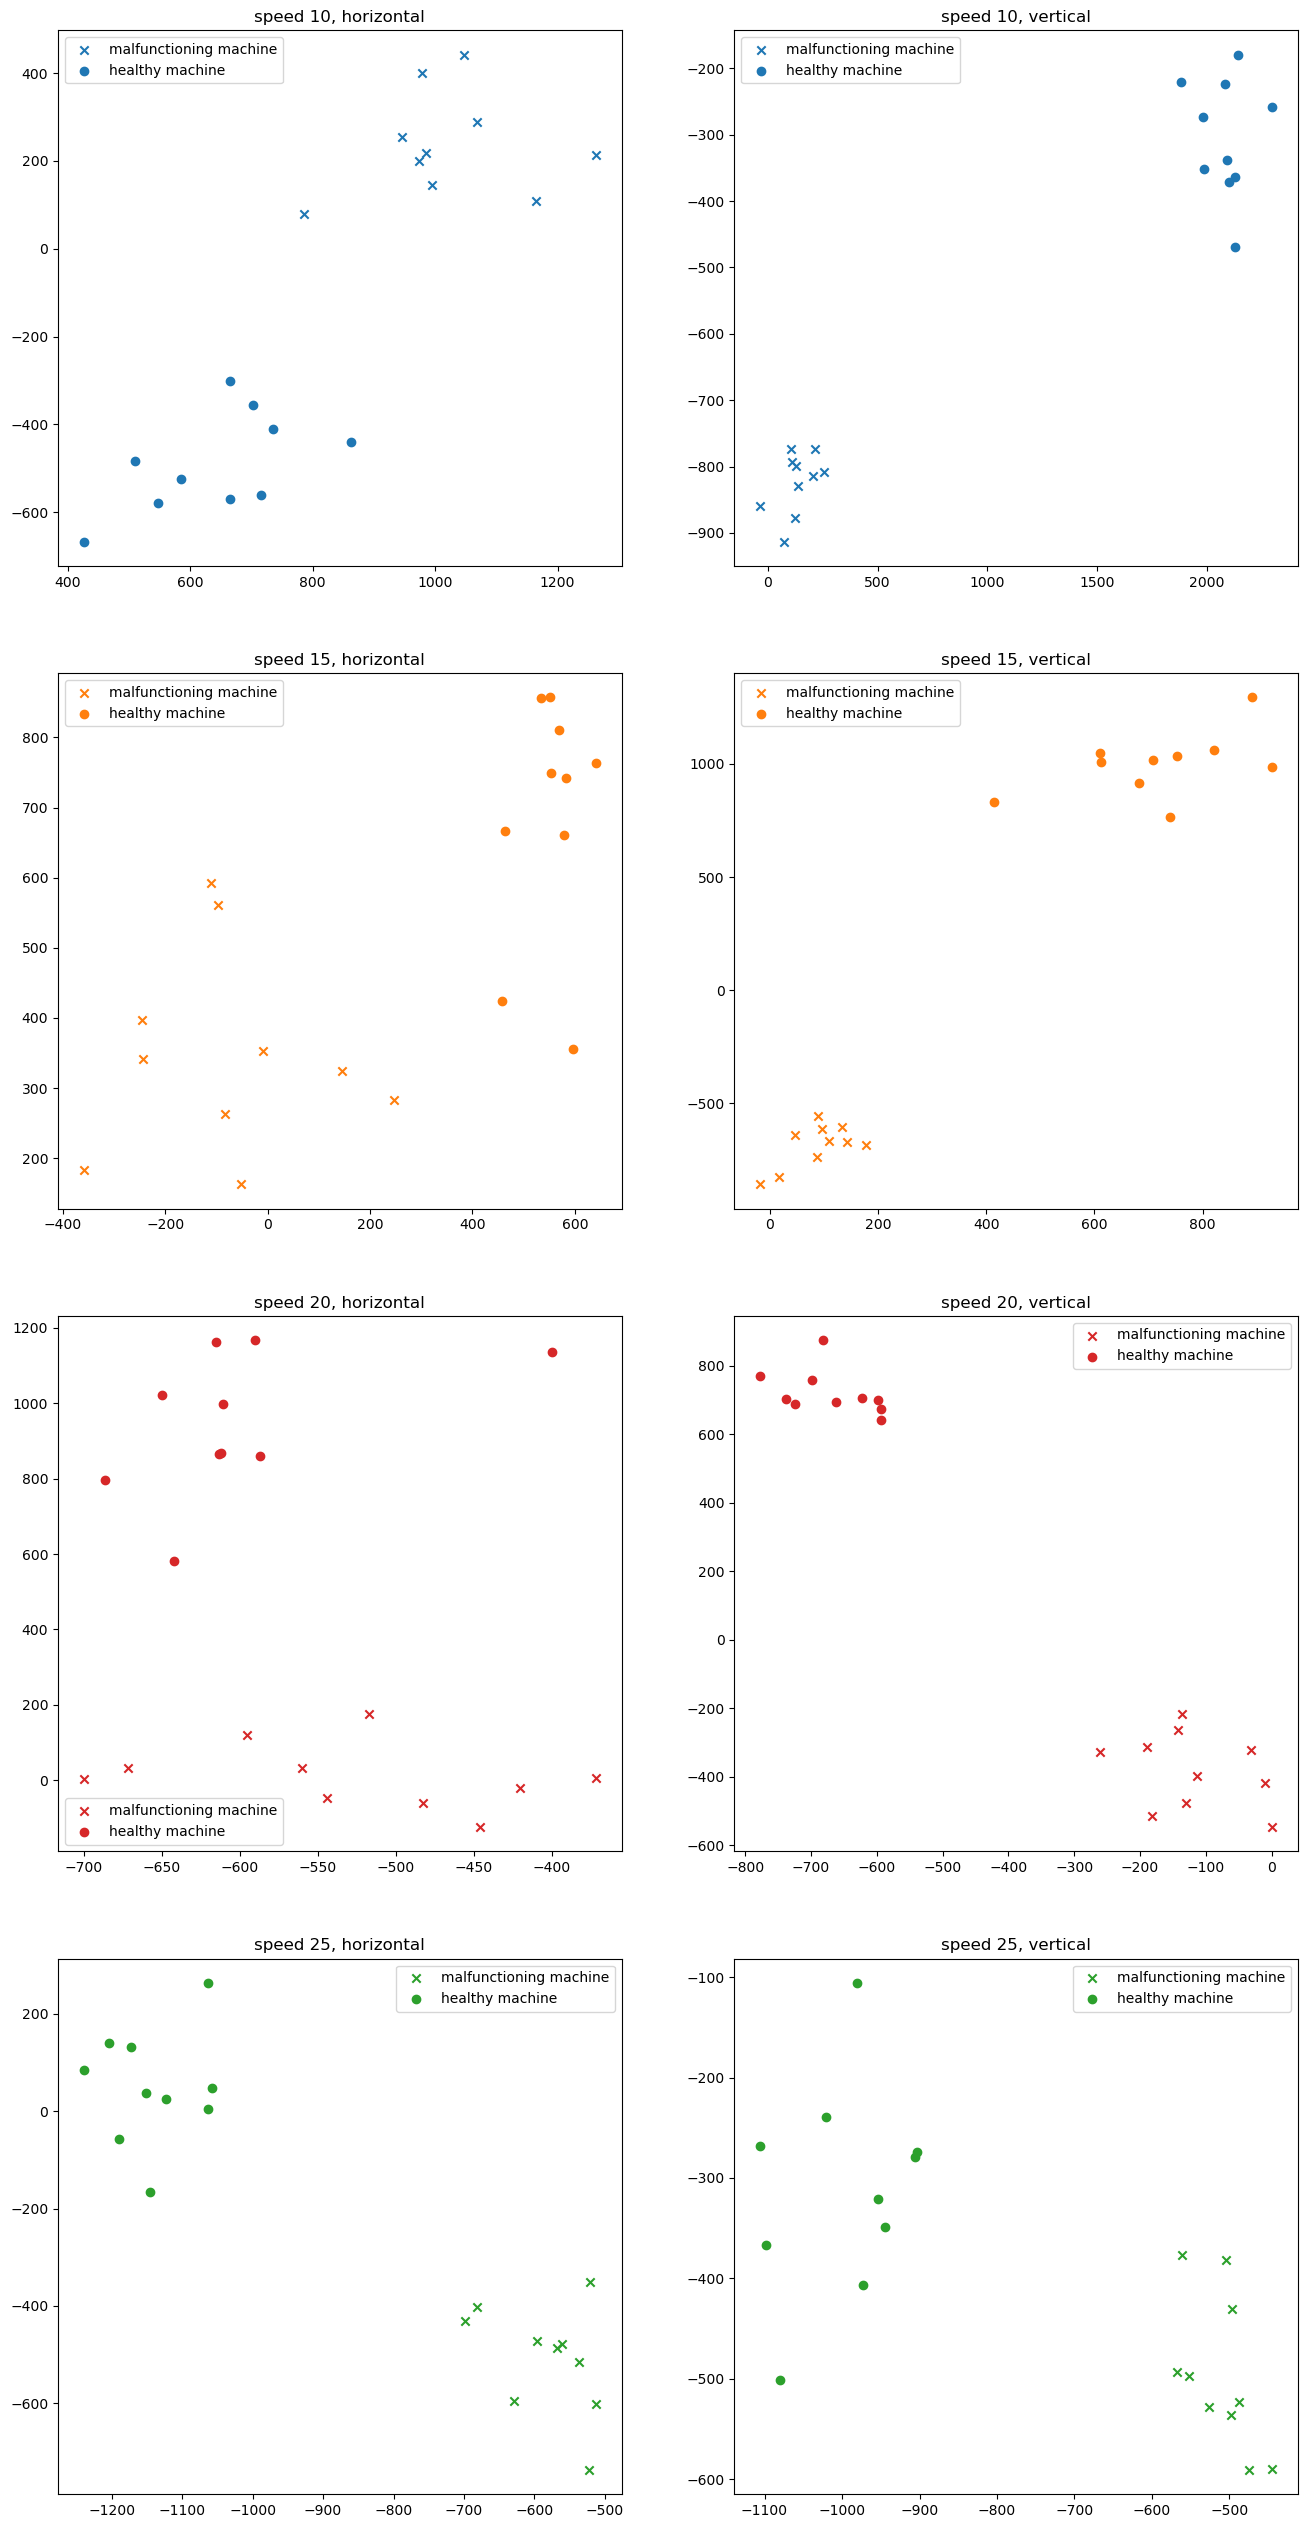

[0.57343067 0.29147349 0.09357534]


In [99]:
pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,i,k] for j in range(0,4) for i in range(0,4) for k in range(0,n_samples)])

fig,ax = plt.subplots(4,2,figsize=(16,32))
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    emb_bad_h = pca.transform(betti_curves[i,0,:])
    emb_good_h = pca.transform(betti_curves[i,2,:])
    ax[i,0].scatter(emb_bad_h[:,0],emb_bad_h[:,1], marker = "x", c=colors[i], label="malfunctioning machine")
    ax[i,0].scatter(emb_good_h[:,0],emb_good_h[:,1], marker = "o", c=colors[i], label="healthy machine")
    ax[i,0].set_title("speed {}, horizontal".format(speeds[i]))
    ax[i,0].legend()
    emb_bad_v = pca.transform(betti_curves[i,1,:])
    emb_good_v = pca.transform(betti_curves[i,3,:])
    ax[i,1].scatter(emb_bad_v[:,0],emb_bad_v[:,1], marker = "x", c=colors[i], label="malfunctioning machine")
    ax[i,1].scatter(emb_good_v[:,0],emb_good_v[:,1], marker = "o", c=colors[i], label="healthy machine")
    ax[i,1].set_title("speed {}, vertical".format(speeds[i]))
    ax[i,1].legend()


plt.show()
print(pca.explained_variance_ratio_)

speed 10, horizontal: malfunctioning avg l2 norm = 23.799140063583206, std = 1.0881941608170942
speed 10, horizontal: helathy avg l2 norm = 16.186964652697867, std = 1.6987123318239796
speed 10, vertical: malfunctioning avg l2 norm = 9.614078377200196, std = 0.9579920107328219
speed 10, vertical: helathy avg l2 norm = 30.241227519936565, std = 1.195928549245803
speed 15, horizontal: malfunctioning avg l2 norm = 22.266713982245015, std = 0.8103243789815797
speed 15, horizontal: helathy avg l2 norm = 25.540731108488927, std = 1.463991707796274
speed 15, vertical: malfunctioning avg l2 norm = 10.890196771908062, std = 1.0858284813463162
speed 15, vertical: helathy avg l2 norm = 27.538293968096404, std = 1.2228039209154462
speed 20, horizontal: malfunctioning avg l2 norm = 21.96018756799156, std = 0.9024173111982267
speed 20, horizontal: helathy avg l2 norm = 27.724381187940878, std = 1.416572901171248
speed 20, vertical: malfunctioning avg l2 norm = 13.797230229459132, std = 1.10071655187

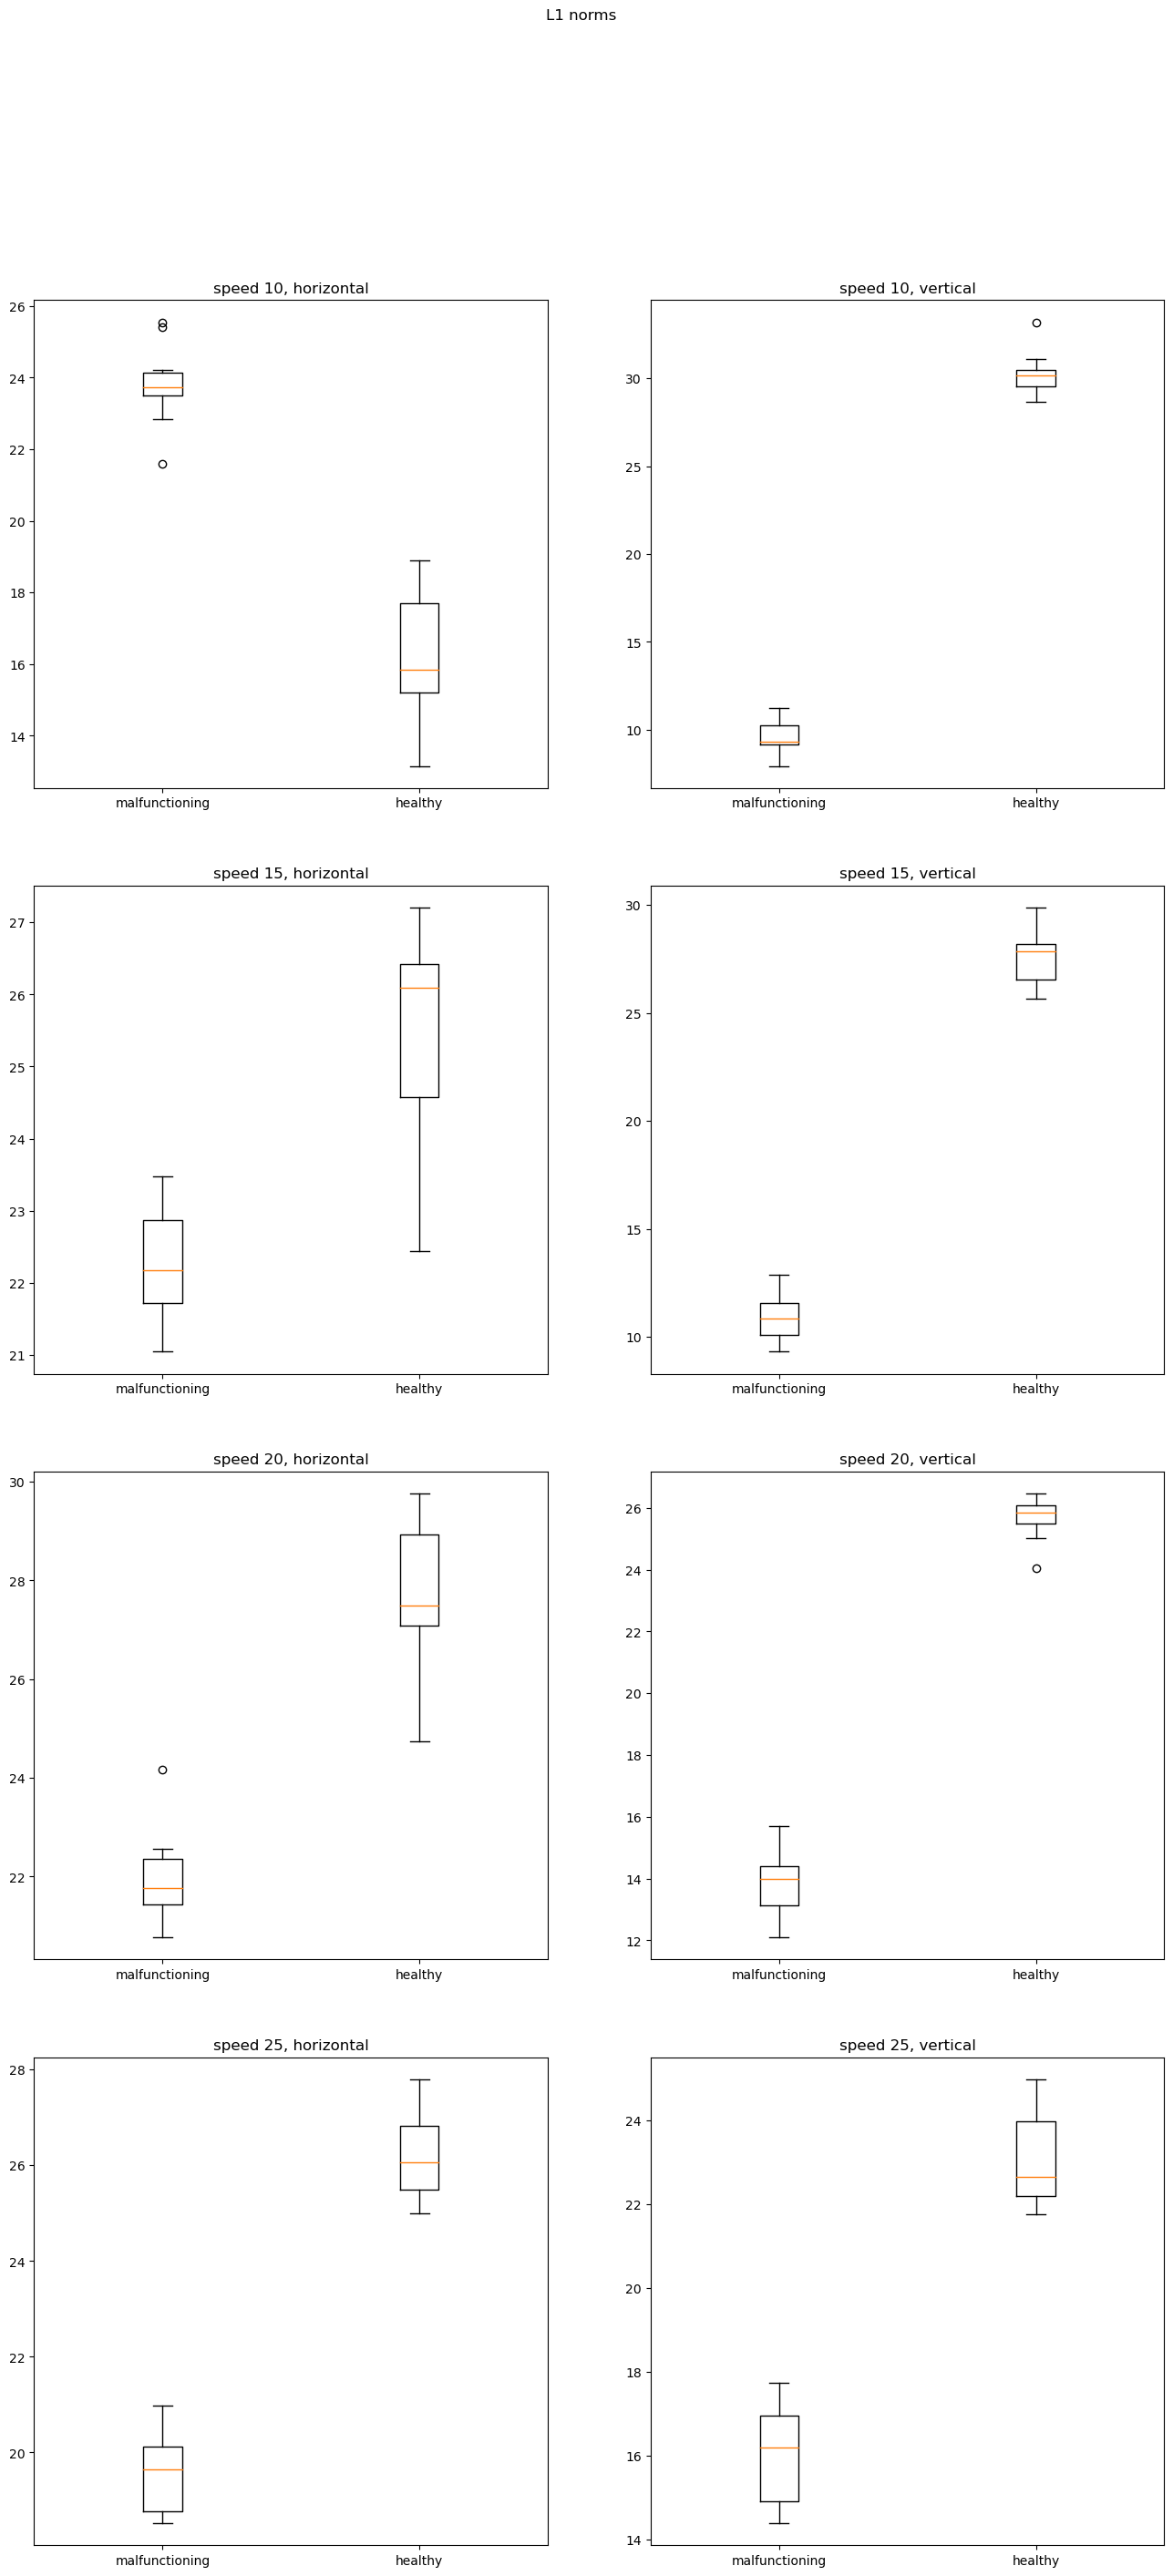

In [105]:
fig,ax = plt.subplots(4,2,figsize=(16,32))

##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    ax[i,0].boxplot([norms[i,0,:],norms[i,2,:]])
    ax[i,0].set_title("speed {}, horizontal".format(speeds[i]))
    ax[i,0].set_xticklabels(["malfunctioning", "healthy"])
    
    ax[i,1].boxplot([norms[i,1,:],norms[i,3,:]])
    ax[i,1].set_title("speed {}, vertical".format(speeds[i]))
    ax[i,1].set_xticklabels(["malfunctioning", "healthy"])

    print("speed {}, horizontal: malfunctioning avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,0,:]), np.std(norms[i,0,:]) ))
    print("speed {}, horizontal: helathy avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,2,:]), np.std(norms[i,2,:]) ))
    print("speed {}, vertical: malfunctioning avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,1,:]), np.std(norms[i,1,:]) ))
    print("speed {}, vertical: helathy avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,3,:]), np.std(norms[i,3,:]) ))
          
          
fig.suptitle("L1 norms")
plt.savefig("vibstand_results/TestRigBoxplot.pdf")

plt.show()

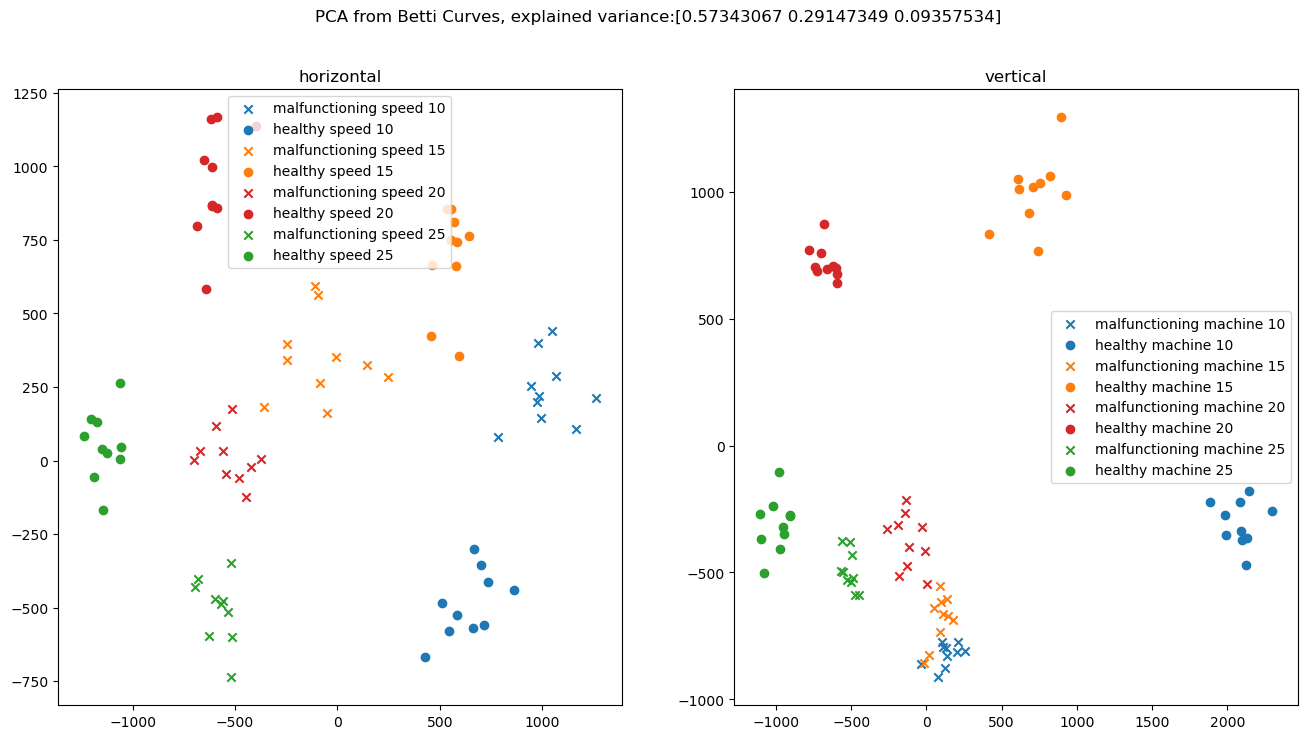

In [104]:
pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,i,k] for j in range(0,4) for i in range(0,4) for k in range(0,n_samples)])

fig,ax = plt.subplots(1,2,figsize=(16,8))
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    emb_bad_h = pca.transform(betti_curves[i,0,:])
    emb_good_h = pca.transform(betti_curves[i,2,:])
    ax[0].scatter(emb_bad_h[:,0],emb_bad_h[:,1], marker = "x", c=colors[i], label="malfunctioning speed {}".format(speeds[i]))
    ax[0].scatter(emb_good_h[:,0],emb_good_h[:,1], marker = "o", c=colors[i], label="healthy speed {}" .format(speeds[i]))
    ax[0].set_title("horizontal")
    ax[0].legend()
    emb_bad_v = pca.transform(betti_curves[i,1,:])
    emb_good_v = pca.transform(betti_curves[i,3,:])
    ax[1].scatter(emb_bad_v[:,0],emb_bad_v[:,1], marker = "x", c=colors[i], label="malfunctioning machine {}".format(speeds[i]))
    ax[1].scatter(emb_good_v[:,0],emb_good_v[:,1], marker = "o", c=colors[i], label="healthy machine {}".format(speeds[i]))
    ax[1].set_title("vertical")
    ax[1].legend()

fig.suptitle("PCA from Betti Curves, explained variance:{}".format(pca.explained_variance_ratio_))
plt.savefig("vibstand_results/TestRigPCA.pdf")

plt.show()

#print()